# Sections
## - Load Reviews
## - Data Exploration of Positive Reviews
## - Create Train and Test Data
### - Preprocess Review Text
### - Create 2 Test groups - "Seen" users and "Unseen" users
### - Understand "User in City" activity distribution
### - Add 1 city data for "Seen" users into Train set
### - Create Final Test Set

## Setup Environment
##### import necessary libraries

In [1]:
import re
import nltk
import os
import pandas
import json
#nltk.download('stopwords') #uncomment on a new system
from nltk.corpus import stopwords
#nltk.download('wordnet') #uncomment on a new system
from sklearn.model_selection import train_test_split

## Load Reviews

In [2]:
def read_data(datafilename):
    data_file = open(datafilename,'r')
    data = []
    for line in data_file:
        data.append(json.loads(line))
    data_file.close()
    return data

In [3]:
reviews='data/yelp_academic_dataset_review.json'

In [4]:
raw=read_data(reviews)
df = pandas.json_normalize(raw,max_level=1)
print(df.shape)
print(df.columns)

(6685900, 9)
Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')


## It is intuitive to train a recommender on "positive" interactions of users. Find out the number of positive reviews and see if its feasible to train only on positive reviews and other "positive" activity.

In [5]:
stars_ranges=df['stars'].value_counts()
print(stars_ranges)

5.0    2933082
4.0    1468985
1.0    1002159
3.0     739280
2.0     542394
Name: stars, dtype: int64


In [6]:
pos_data=df[df['stars']>=4]

In [8]:
users_with_pos_reviews=pos_data['user_id'].nunique()
print(users_with_pos_reviews)

1251983


In [9]:
businesses_with_pos_reviews=pos_data['business_id'].nunique()
print(businesses_with_pos_reviews)

183477


In [13]:
print(pos_data.iloc[10]['text'])

Our family LOVES the food here. Quick, friendly, delicious, and a great restaurant to take kids to. 5 stars!


## Conclusion: There are enough users with positive reviews and enough businesses with positive reviews to train starspace embeddings model.

## Load business data to find cities and metadata of the businesses with positive reviews

In [14]:
%%time
bizdata='data/yelp_academic_dataset_business.json'
raw=read_data(bizdata)
bizdf = pandas.DataFrame(raw)
print(bizdf.shape)
print(bizdf.columns)

(192609, 14)
Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')
CPU times: user 13.4 s, sys: 49.7 s, total: 1min 3s
Wall time: 1min 46s


In [15]:
bizdf=bizdf.drop(['address','state', 'postal_code',
       'latitude', 'longitude','attributes', 'hours'],axis=1)

In [16]:
print(bizdf.shape)
print(bizdf.columns)

(192609, 7)
Index(['business_id', 'name', 'city', 'stars', 'review_count', 'is_open',
       'categories'],
      dtype='object')


In [17]:
%%time
pos_data_with_dets=pandas.merge(pos_data,bizdf,how='left',left_on='business_id',right_on='business_id')

CPU times: user 7.68 s, sys: 21.6 s, total: 29.3 s
Wall time: 51 s


In [18]:
print(pos_data_with_dets.shape)
print(pos_data_with_dets.columns)

(4402067, 15)
Index(['review_id', 'user_id', 'business_id', 'stars_x', 'useful', 'funny',
       'cool', 'text', 'date', 'name', 'city', 'stars_y', 'review_count',
       'is_open', 'categories'],
      dtype='object')


In [19]:
#Nice, every business has a city
chkna=pos_data_with_dets['city'].isna().sum()
print(chkna)

0


# Create Train and Test data

In [ ]:
uniq_user_ids=pos_data['user_id'].unique()
print(uniq_user_ids.shape)

In [22]:
print(pos_data.shape)

(4402067, 9)


## Preprocess User Review Text:
<ul>
    <li> Remove weird symbols </li>
    <li> Remove stopwords </li>
    <li> Lemmatize the words </li>
</ul>

In [26]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
stemmer = nltk.stem.WordNetLemmatizer()
def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = re.sub(REPLACE_BY_SPACE_RE,' ',text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(BAD_SYMBOLS_RE,' ',text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text_words=text.split(' ')
    #lowercase,remove urls,delete stopwords and blanks
    resultwords= []
    for word in text_words:
        if len(word)<=0: continue
        if word in STOPWORDS: continue
        if word.find('http')==0: word='url'
        resultwords.append(word)
        
    #resultwords  = [word for word in text_words if word.lower() not in STOPWORDS and len(word)>0] # delete stopwords from text
    final_words = [stemmer.lemmatize(token) for token in resultwords] #lemmatize words
    text = ' '.join(final_words) 
    return text

In [27]:
%%time
pos_data_with_dets['text_prep']=pos_data_with_dets['text'].apply(text_prepare)

CPU times: user 16min 11s, sys: 24.1 s, total: 16min 35s
Wall time: 17min 21s


In [30]:
print("Raw")
print(pos_data_with_dets.iloc[100]['text'])
print("Prepped")
print(pos_data_with_dets.iloc[100]['text_prep'])

Raw
It was my first time here and I was definitely
Impressed. The groomers work and etiquette was lovely. I usually need the works when it comes to my little schweenie mix. ;) I'm glad I went to her and will most definitely be back!
Prepped
first time definitely impressed groomers work etiquette lovely usually need work come little schweenie mix glad went definitely back


In [29]:
print(pos_data.columns)
print(pos_data_with_dets.columns)

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')
Index(['review_id', 'user_id', 'business_id', 'stars_x', 'useful', 'funny',
       'cool', 'text', 'date', 'name', 'city', 'stars_y', 'review_count',
       'is_open', 'categories', 'text_prep'],
      dtype='object')


In [31]:
pos_data_with_dets.iloc[:100].to_csv('100pos_data.csv',index=False)

In [34]:
pos_data_with_dets=pos_data_with_dets.rename({'stars_x':'review_stars','stars_y':'business_stars'},axis=1)

In [35]:
print(pos_data_with_dets.columns)

Index(['review_id', 'user_id', 'business_id', 'review_stars', 'useful',
       'funny', 'cool', 'text', 'date', 'name', 'city', 'business_stars',
       'review_count', 'is_open', 'categories', 'text_prep'],
      dtype='object')


In [36]:
pos_data_with_dets=pos_data_with_dets.drop(['text'],axis=1)

In [37]:
pos_data_with_dets.to_pickle("data/rec_task_data.pkl")

# Create 2 Test groups - "Seen" users and "Unseen" users

### Refer to "Metrics" Slides

In [41]:
userids=pos_data['user_id'].unique()
print(userids.shape)

(1251983,)


In [43]:
train_users,rem_users=train_test_split(userids,random_state=42,test_size=0.05)
test_seen_users,test_unseen_users=train_test_split(rem_users,random_state=42,test_size=0.4)
l=[train_users.shape[0],test_seen_users.shape[0],test_unseen_users.shape[0]]
l2=[e*100/userids.shape[0] for e in l]
print(l)
print(l2)

[1189383, 37560, 25040]
[94.99993210770434, 3.0000407353773975, 2.000027156918265]


In [48]:
%%time
train_data=pos_data_with_dets[pos_data_with_dets['user_id'].isin(train_users)]
#check
print(train_data.shape)
print(train_data['user_id'].nunique())

(4185518, 15)
1189383
CPU times: user 4.93 s, sys: 5.34 s, total: 10.3 s
Wall time: 14.5 s


In [49]:
%%time
train_test_seen_users=pos_data_with_dets[pos_data_with_dets['user_id'].isin(test_seen_users)]
#check
print(train_test_seen_users.shape)
print(train_test_seen_users['user_id'].nunique())

(129631, 15)
37560
CPU times: user 1.12 s, sys: 64.3 ms, total: 1.18 s
Wall time: 1.23 s


In [44]:
test_unseen_data=pos_data_with_dets[pos_data_with_dets['user_id'].isin(test_unseen_users)]

In [47]:
print(test_unseen_data.shape)
print(test_unseen_data['user_id'].nunique())

(86918, 15)
25040


In [50]:
%%time
train_data['train_data_text']=train_data.groupby(['user_id'])['text_prep'].transform(lambda x: '\t'.join(x))
print(train_data.shape)
print(train_data.columns)

(4185518, 16)
Index(['review_id', 'user_id', 'business_id', 'review_stars', 'useful',
       'funny', 'cool', 'date', 'name', 'city', 'business_stars',
       'review_count', 'is_open', 'categories', 'text_prep',
       'train_data_text'],
      dtype='object')
CPU times: user 4min 21s, sys: 54.2 s, total: 5min 15s
Wall time: 6min 37s


In [51]:
train_data_sub=train_data.drop(['review_id','business_id','review_stars','useful','funny','cool',
                                'date','name','city','business_stars','review_count','is_open',
                                'categories','text_prep'],axis=1)
print(train_data_sub.columns)

Index(['user_id', 'train_data_text'], dtype='object')


In [52]:
#this took 2-3 mins. to finish
train_data_sub.drop_duplicates(inplace=True)
print(train_data_sub.shape)
print(train_data_sub.columns)

(1189383, 2)
Index(['user_id', 'train_data_text'], dtype='object')


In [53]:
%%time
train_data_sub.to_pickle("data/rec_task_train_set1.pkl")

CPU times: user 1.6 s, sys: 3.06 s, total: 4.66 s
Wall time: 6.67 s


In [54]:
#check
train_data_sub['train_data_text'][:100].to_csv('data/rec_task_train_set1.txt',header=None,index=False)

In [64]:
train_data_sub['train_data_text'].to_csv('data/rec_task_train_set1.txt',header=None,index=False)

## To create tests for Seen users, select users with activity in 2 cities. Put one city activity in training and another city activity in test. 

In [56]:
test_seen_user_city=train_test_seen_users[['user_id','city']]

In [58]:
user_city_stats=test_seen_user_city.groupby(['user_id']).size()

### Understand "User in City" activity distribution.
- How many cities are users active in?
- How skewed is this distribution?

<AxesSubplot:>

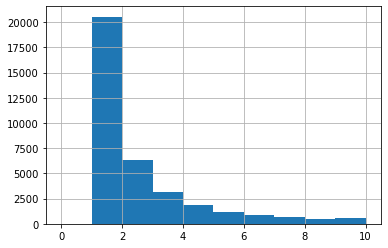

In [63]:
user_city_stats.hist(bins=10,range=(0,10))

In [67]:
user_city_stats[:5]

user_id
--6D_IuxyKTN53pHi904ag     2
--Br-QsbO9ad5GbZxVGxaw     4
--BumyUHiO_7YsHurb9Hkw    46
--F1tbZdtqrqx_Uh8rFFBw     3
--OifHfYcX6tFOdcVCqXsA     1
dtype: int64

In [75]:
user_city_stats.index[:5]

Index(['--6D_IuxyKTN53pHi904ag', '--Br-QsbO9ad5GbZxVGxaw',
       '--BumyUHiO_7YsHurb9Hkw', '--F1tbZdtqrqx_Uh8rFFBw',
       '--OifHfYcX6tFOdcVCqXsA'],
      dtype='object', name='user_id')

In [76]:
users1city=user_city_stats[user_city_stats==1].index[:]

In [77]:
users1city[:5]

Index(['--OifHfYcX6tFOdcVCqXsA', '--iYUTSkH-LjfQt9EN8Nnw',
       '--rriu0TdaMVM6X11S3qAA', '--zWE4s60CxcJp3S3S0F1g',
       '-02x76pkdZIneICXoPKNoA'],
      dtype='object', name='user_id')

In [78]:
users2cities=user_city_stats[user_city_stats>=2].index[:]

In [79]:
print(users1city.shape)
print(users2cities.shape)

(20543,)
(17017,)


## Add "Seen" users activity in 1 or more cities to training partition

In [80]:
train_users1city=train_test_seen_users[train_test_seen_users['user_id'].isin(users1city)]

In [81]:
print(train_users1city.shape)
print(train_users1city.columns)

(20543, 15)
Index(['review_id', 'user_id', 'business_id', 'review_stars', 'useful',
       'funny', 'cool', 'date', 'name', 'city', 'business_stars',
       'review_count', 'is_open', 'categories', 'text_prep'],
      dtype='object')


In [82]:
%%time
train_users1city['train_data_text']=train_users1city.groupby(['user_id'])['text_prep'].transform(lambda x: '\t'.join(x))
train_users1city_sub=train_users1city.drop(['review_id','business_id','review_stars','useful','funny','cool',
                                'date','name','city','business_stars','review_count','is_open',
                                'categories','text_prep'],axis=1)
train_users1city_sub.drop_duplicates(inplace=True)
print(train_users1city_sub.shape)
print(train_users1city_sub.columns)

(20543, 2)
Index(['user_id', 'train_data_text'], dtype='object')
CPU times: user 4.65 s, sys: 1.36 s, total: 6.01 s
Wall time: 8.52 s


In [83]:
train_users1city_sub.to_pickle("data/rec_task_train_set2.pkl")
train_users1city_sub['train_data_text'].to_csv('data/rec_task_train_set2.txt',header=None,index=False)

In [89]:
train_test_users2cities=train_test_seen_users[train_test_seen_users['user_id'].isin(users2cities)]

In [96]:
#try for one
userid=train_test_users2cities['user_id'].iloc[100]

userdata=train_test_users2cities[train_test_users2cities['user_id']==userid]
user_city_stats=userdata.groupby(['city']).size().sort_values()
max_city=user_city_stats.index[0]
print(max_city)
print(user_city_stats)

Henderson
city
Henderson           1
North Las Vegas     3
Las Vegas          56
dtype: int64


In [99]:
print(userdata.columns)

Index(['review_id', 'user_id', 'business_id', 'review_stars', 'useful',
       'funny', 'cool', 'date', 'name', 'city', 'business_stars',
       'review_count', 'is_open', 'categories', 'text_prep'],
      dtype='object')


In [ ]:
#%%time
trainset3=[]
seen_tests=[]
counter=0
for userid in users2cities:
    userdata=train_test_users2cities[train_test_users2cities['user_id']==userid]
    user_city_stats=userdata.groupby(['city']).size().sort_values()
    test_city=user_city_stats.index[0]
    test_cases=userdata[userdata['city']==test_city]
    seen_tests.append(test_cases)
    fortrain=userdata[~(userdata['city']==test_city)]
    trainset3.append(fortrain)
    counter+=1
    if counter%1000==0:
        print("Done "+str(counter))

In [105]:
%%time
train_users2cities=pandas.concat(trainset3,ignore_index=True)
train_users2cities['train_data_text']=train_users2cities.groupby(['user_id'])['text_prep'].transform(lambda x: '\t'.join(x))
train_users2cities_sub=train_users2cities.drop(['review_id','business_id','review_stars','useful','funny','cool',
                                'date','name','city','business_stars','review_count','is_open',
                                'categories','text_prep'],axis=1)
train_users2cities_sub.drop_duplicates(inplace=True)
print(train_users2cities_sub.shape)
print(train_users2cities_sub.columns)

(9614, 2)
Index(['user_id', 'train_data_text'], dtype='object')
CPU times: user 15.8 s, sys: 5.92 s, total: 21.7 s
Wall time: 33.5 s


In [106]:
train_users2cities_sub.to_pickle("data/rec_task_train_set3.pkl")
train_users2cities_sub['train_data_text'].to_csv('data/rec_task_train_set3.txt',header=None,index=False)

In [107]:
all_train_data_sub=pandas.concat([train_data_sub,train_users1city_sub,train_users2cities_sub],ignore_index=True)
print(all_train_data_sub.shape)
all_train_data_sub.to_pickle("data/rec_task_train_set_all.pkl")

(1219540, 2)


# Create Final Test data for "Seen" and "Unseen" Users

In [108]:
test_seen_users=pandas.concat(seen_tests,ignore_index=True)

In [109]:
print(test_seen_users.shape)
print(test_seen_users.columns)

(37977, 15)
Index(['review_id', 'user_id', 'business_id', 'review_stars', 'useful',
       'funny', 'cool', 'date', 'name', 'city', 'business_stars',
       'review_count', 'is_open', 'categories', 'text_prep'],
      dtype='object')


In [110]:
test_seen_users.to_pickle("data/rec_task_test_seen_users.pkl")

In [111]:
print(test_unseen_data.shape)
print(test_unseen_data.columns)

(86918, 15)
Index(['review_id', 'user_id', 'business_id', 'review_stars', 'useful',
       'funny', 'cool', 'date', 'name', 'city', 'business_stars',
       'review_count', 'is_open', 'categories', 'text_prep'],
      dtype='object')


In [113]:
test_unseen_data.to_pickle("data/rec_task_test_unseen_users.pkl")